In [1]:
import random

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(8,5)})

# Гипотезы и метрики

**Гипотеза:** Списать можно у товарища по ходу экзамена.
   
**Метрики:**
- Доля совпадающих ответов. Но если ответы правильные?
- Доля совпадающих неправильных ответов.
  Отдельно можно сделать акцент на совпадающих редких неправильных ответах.

**Гипотеза:** Списать можно из заранее заготовленных / куда-либо выложенных ответов на экзамен.

**Метрики:**
- Доля введённых подряд ответов. Бывают ситуации, когда человек заранее решает все задания, а потом вносит их в ситсему. Но это не наш случай: задания открываются последовательно. Однако бывает, что человек вводит ответы от безысходности.
- Доля введённых подряд правильных ответов. Что такое «введённые подряд» ответы?

# Предобработка данных

In [3]:
exam = pd.read_csv('datasets/sirius/exam.csv')
user_answer = pd.read_csv('datasets/sirius/user_answer.csv')

In [4]:
exam

,id,start_date,tasks_cnt
0,1,2023-12-15 10:00:00,16
1,2,2023-12-20 10:00:00,4


In [42]:
user_answer[user_answer.exam_id == 1]

,exam_id,user_id,task_ind,answer,verdict,time
0,1,98,1,1,OK,2023-12-15 10:22:51
1,1,98,2,0,WA,2023-12-15 11:16:21
2,1,98,3,1,OK,2023-12-15 11:28:44
3,1,98,4,0,WA,2023-12-15 11:54:32
4,1,98,5,0,WA,2023-12-15 12:30:11
...,...,...,...,...,...,...
2235,1,89,12,3,OK,2023-12-15 10:03:36
2236,1,89,13,2,OK,2023-12-15 10:04:03
2237,1,89,14,0,OK,2023-12-15 10:04:04
2238,1,89,15,0,OK,2023-12-15 10:04:09


In [43]:
2240/16

140.0

/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(    task_ind                time
 0          1 2023-12-15 10:22:51
 1          2 2023-12-15 11:16:21
 2          3 2023-12-15 11:28:44
 3          4 2023-12-15 11:54:32
 4          5 2023-12-15 12:30:11
 5          6 2023-12-15 13:44:22
 6          7 2023-12-15 13:44:25
 7          8 2023-12-15 13:57:14
 8          9 2023-12-15 14:02:11
 9         10 2023-12-15 14:19:18
 10        11 2023-12-15 14:31:36
 11        12 2023-12-15 14:43:29
 12        13 2023-12-15 14:43:37
 13        14 2023-12-15 15:03:08
 14        15 2023-12-15 15:55:17
 15        16 2023-12-15 15:57:25,
 <Axes: xlabel='task_ind', ylabel='time'>)

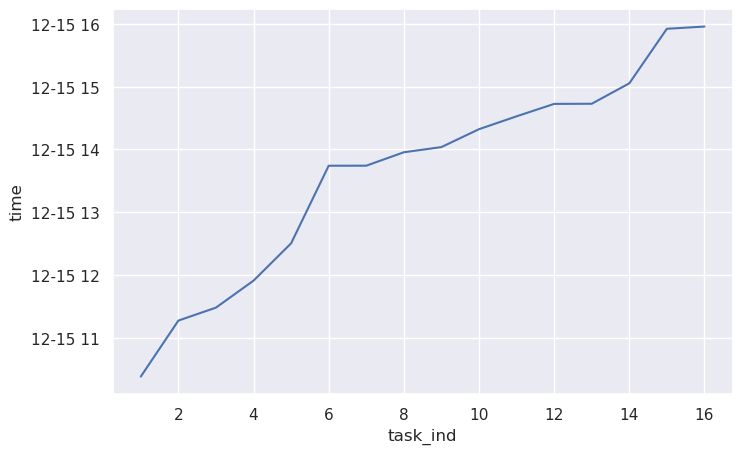

In [41]:
usr = user_answer[user_answer.user_id == 98]
usr = usr[usr.exam_id == 1]
usr = usr.drop(columns=['user_id', 'exam_id', 'verdict', 'answer'], axis=1)
usr, sns.lineplot(x=usr.task_ind, y=usr.time)

In [7]:
user_answer.exam_id.value_counts()

exam_id
1    2240
2    2120
Name: count, dtype: int64

In [8]:
user_answer.isna().sum()

exam_id     0
user_id     0
task_ind    0
answer      0
verdict     0
time        0
dtype: int64

In [9]:
user_answer.dtypes

exam_id      int64
user_id      int64
task_ind     int64
answer       int64
verdict     object
time        object
dtype: object

In [10]:
user_answer['time'] = pd.to_datetime(
    user_answer['time'],
    format='%Y-%m-%d %H-%M-%S'
)

In [11]:
user_answer.dtypes

exam_id              int64
user_id              int64
task_ind             int64
answer               int64
verdict             object
time        datetime64[ns]
dtype: object

Известные факты:
- задания в выдаются по очереди (без возможности вернуться к предыдущему)
- чтобы завершить сдачу экзамена, необходимо ввести ответы на все вопросы

На что обращаем внимание:
- очередность выполнения заданий (с 1 по n-нное)
- временные границы (с момента старта экзамена и не дольше чем ?конец текущего дня?)
- промежутки между заданиями (в основном интересует минимальный, скажем 1 минута, чтобы исключить списывание и только в случае правильных ответов, неправильные могут быть следствием "проматывания" вопросов, по разным причинам)

В предложенном разборе вообще не забействована информация о времени сдачи, а сравниваются только степени похожести векторов ответов студентов (попарно).

# Вычисление метрик

## Списывание у коллег

In [66]:
user_answer_exam_1 = user_answer[user_answer['exam_id'] == 1]

In [67]:
user_answer_exam_1 = user_answer_exam_1.drop(columns=['exam_id', 'time'], axis=1)
user_answer_exam_1.head(3)

,user_id,task_ind,answer,verdict
0,98,1,1,OK
1,98,2,0,WA
2,98,3,1,OK


In [68]:
user_answer_exam_1['user_id'].nunique()

140

In [69]:
user_answer_exam_1 \
    .merge(user_answer_exam_1, on='task_ind', suffixes=('_1', '_2'))

,user_id_1,task_ind,answer_1,verdict_1,user_id_2,answer_2,verdict_2
0,98,1,1,OK,98,1,OK
1,98,1,1,OK,49,1,OK
2,98,1,1,OK,94,1,OK
3,98,1,1,OK,118,1,OK
4,98,1,1,OK,34,0,WA
...,...,...,...,...,...,...,...
313595,89,16,1,OK,17,1,OK
313596,89,16,1,OK,137,1,OK
313597,89,16,1,OK,32,3,WA
313598,89,16,1,OK,102,1,OK


In [70]:
user_to_user_data_exam_1 = user_answer_exam_1 \
    .merge(user_answer_exam_1, on='task_ind', suffixes=('_1', '_2'))

In [71]:
user_to_user_data_exam_1['key'] = \
    user_to_user_data_exam_1.apply(
        lambda x: (int(min(x['user_id_1'], x['user_id_2'])), int(max(x['user_id_1'], x['user_id_2']))), 
        axis=1
    )

In [72]:
user_to_user_data_exam_1 = user_to_user_data_exam_1 \
    [user_to_user_data_exam_1['user_id_1'] != user_to_user_data_exam_1['user_id_2']]

In [73]:
len(user_to_user_data_exam_1)

311360

In [74]:
user_to_user_data_exam_1

,user_id_1,task_ind,answer_1,verdict_1,user_id_2,answer_2,verdict_2,key
1,98,1,1,OK,49,1,OK,"(49, 98)"
2,98,1,1,OK,94,1,OK,"(94, 98)"
3,98,1,1,OK,118,1,OK,"(98, 118)"
4,98,1,1,OK,34,0,WA,"(34, 98)"
5,98,1,1,OK,140,0,WA,"(98, 140)"
...,...,...,...,...,...,...,...,...
313594,89,16,1,OK,29,1,OK,"(29, 89)"
313595,89,16,1,OK,17,1,OK,"(17, 89)"
313596,89,16,1,OK,137,1,OK,"(89, 137)"
313597,89,16,1,OK,32,3,WA,"(32, 89)"


In [75]:
user_to_user_data_exam_1 = user_to_user_data_exam_1[
    user_to_user_data_exam_1['answer_1'] == user_to_user_data_exam_1['answer_2']
]

In [76]:
user_to_user_data_exam_1

,user_id_1,task_ind,answer_1,verdict_1,user_id_2,answer_2,verdict_2,key
1,98,1,1,OK,49,1,OK,"(49, 98)"
2,98,1,1,OK,94,1,OK,"(94, 98)"
3,98,1,1,OK,118,1,OK,"(98, 118)"
7,98,1,1,OK,114,1,OK,"(98, 114)"
14,98,1,1,OK,4,1,OK,"(4, 98)"
...,...,...,...,...,...,...,...,...
313593,89,16,1,OK,77,1,OK,"(77, 89)"
313594,89,16,1,OK,29,1,OK,"(29, 89)"
313595,89,16,1,OK,17,1,OK,"(17, 89)"
313596,89,16,1,OK,137,1,OK,"(89, 137)"


In [77]:
exam

,id,start_date,tasks_cnt
0,1,2023-12-15 10:00:00,16
1,2,2023-12-20 10:00:00,4


In [78]:
user_similarity_frac = user_to_user_data_exam_1 \
    .groupby(['user_id_1', 'user_id_2'], as_index=False) \
    .agg({'verdict_1': lambda x: len(x) / 16}) \
    .rename(columns={'verdict_1': 'similarity'})

In [79]:
user_similarity_frac

,user_id_1,user_id_2,similarity
0,1,2,0.5625
1,1,3,0.5000
2,1,4,0.2500
3,1,5,0.5625
4,1,6,0.3125
...,...,...,...
19219,140,135,0.7500
19220,140,136,0.6250
19221,140,137,0.0625
19222,140,138,0.6250


/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='similarity', ylabel='Count'>

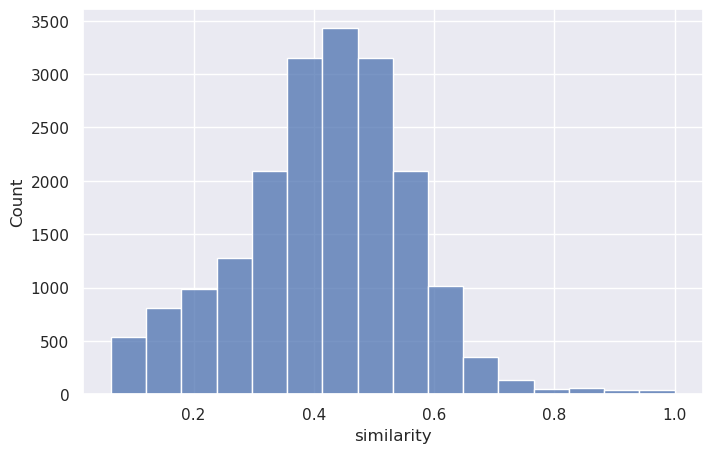

In [80]:
sns.histplot(user_similarity_frac['similarity'], bins=16)

In [81]:
user_similarity_frac['similarity'] \
    .value_counts() \
    .sort_index()

similarity
0.0625     532
0.1250     812
0.1875     986
0.2500    1274
0.3125    2094
0.3750    3152
0.4375    3436
0.5000    3152
0.5625    2096
0.6250    1016
0.6875     350
0.7500     134
0.8125      50
0.8750      62
0.9375      42
1.0000      36
Name: count, dtype: int64

In [82]:
user_similarity_frac \
    .groupby('user_id_1', as_index=False) \
    .agg({'similarity': 'max'}) \
    ['similarity'].value_counts().sort_index()

similarity
0.5625     3
0.6250    11
0.6875    30
0.7500    33
0.8125    11
0.8750    10
0.9375    17
1.0000    25
Name: count, dtype: int64

/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='similarity', ylabel='Count'>

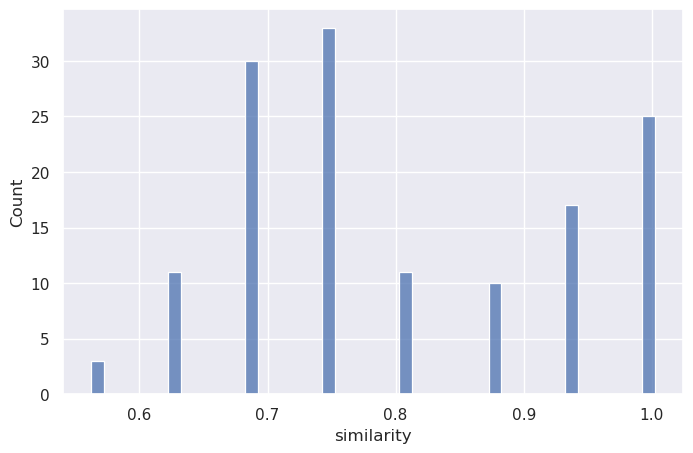

In [83]:
sns.histplot(user_similarity_frac \
    .groupby('user_id_1', as_index=False) \
    .agg({'similarity': 'max'}) \
    ['similarity'], binwidth=0.01)

In [84]:
suspicious_users_exam_1 = user_similarity_frac[user_similarity_frac['similarity'] >= 0.85].copy(deep=True)

In [85]:
suspicious_users_exam_1

,user_id_1,user_id_2,similarity
37,1,39,1.0000
129,1,131,1.0000
221,2,84,1.0000
1125,9,19,0.9375
1161,9,55,0.9375
...,...,...,...
18692,137,17,0.8750
18715,137,41,0.8750
18750,137,77,0.8750
18762,137,89,0.8750


In [86]:
suspicious_users_exam_1.user_id_1.nunique()

52

In [87]:
user_success_df = user_answer_exam_1[
    user_answer_exam_1['user_id'].isin(suspicious_users_exam_1['user_id_1'])] \
    .groupby('user_id', as_index=False) \
    .agg({'verdict': lambda x: (x == 'OK').sum() / len(x)}) \
    .rename(columns={'verdict': 'success_rate'})

In [88]:
user_success_df

,user_id,success_rate
0,1,0.1875
1,2,0.1250
2,9,0.1875
3,10,0.0625
4,13,0.0000
5,17,1.0000
6,19,0.1875
7,20,0.2500
8,21,0.2500
9,26,0.1250


In [93]:
user_success_df['success_rate'].value_counts().sort_index()

success_rate
0.0000     7
0.0625     8
0.1250     6
0.1875    11
0.2500     6
0.3125     4
0.3750     1
0.8125     1
0.8750     4
1.0000     4
Name: count, dtype: int64

In [94]:
user_success_df = user_answer_exam_1[user_answer_exam_1['user_id'].isin(suspicious_users_exam_1.user_id_1)] \
    .groupby('user_id', as_index=False) \
    .agg({'verdict': lambda x: (x == 'OK').sum() / len(x)}) \
    .rename(columns={'verdict': 'success_rate'})
successful_users = frozenset(user_success_df[user_success_df['success_rate'] >= 0.85]['user_id'])

In [97]:
suspicious_users_exam_1[suspicious_users_exam_1['user_id_1'].isin(
    user_success_df[user_success_df['success_rate'] < 0.85]['user_id']
)]

,user_id_1,user_id_2,similarity
37,1,39,1.0000
129,1,131,1.0000
221,2,84,1.0000
1125,9,19,0.9375
1161,9,55,0.9375
...,...,...,...
17895,131,39,1.0000
18099,132,110,0.9375
18109,132,120,0.9375
18461,135,56,0.8750


In [98]:
res_df = suspicious_users_exam_1[suspicious_users_exam_1['user_id_1'].isin(
    user_success_df[user_success_df['success_rate'] < 0.85]['user_id']
)]

In [99]:
res_df.user_id_1.unique()

array([  1,   2,   9,  10,  13,  19,  20,  21,  26,  36,  39,  40,  53,
        54,  55,  56,  57,  58,  61,  68,  72,  78,  79,  80,  84,  86,
        90,  94,  96, 102, 104, 105, 110, 111, 115, 116, 120, 123, 129,
       130, 131, 132, 135, 136])

In [100]:
res_df['user_id_1'].nunique()

44